In [30]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sentiment import sentiment_vader
from imdb_api.imdbscraper import ImdbScraper

### Trailers

In [11]:
file_list = ['hbo', 'amazon', 'netflix']
dfs = []
for file in file_list:
    df = pd.read_csv('../data/' + file + '.csv')
    df['network'] = file
    dfs.append(df)

trailers = pd.concat(dfs)

### Comments and sentiment

In [15]:
file_list = ['hbo_comments', 'amazon_comments']  # , 'netflix_comments']
dfs = []
for file in file_list:
    df = pd.read_csv('../comments/' + file + '.csv')
    dfs.append(df)

comments = pd.concat(dfs)

In [89]:
comments['sentiment_raw'] = comments.textOriginal.astype(str).apply(sentiment_vader)

In [91]:
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
comments['sentiment_score'] = comments.sentiment_raw.str[-1].map(sentiment_map)
comments_agg = comments.groupby('videoId').agg(
    num_comments=('commentId', 'count'),
    sentiment_agg=('sentiment_score', 'mean')
).reset_index()

### Mapping imdb and youtube

In [27]:
file_list = ['hbo', 'amazon', 'netflix']
dfs = []
for file in file_list:
    df = pd.read_csv('../data/match/' + file + '_match.csv', delimiter=';')
    dfs.append(df)

match = pd.concat(dfs).dropna()

### IMDb

In [17]:
imdb = pd.read_csv('../imdb/title.basics.tsv', delimiter='\t')
ratings = pd.read_csv('../imdb/title.ratings.tsv', delimiter='\t')
imdb = imdb.merge(ratings, on='tconst')

<ipython-input-17-a8dec8d5b7d6>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb = pd.read_csv('../imdb/title.basics.tsv', delimiter='\t')


### IMDb release dates

In [45]:
# scraper = ImdbScraper()
# scraper.scrape_dates(match.tconst, verbose=True, timeout=1)

In [87]:
release_dates = pd.DataFrame(scraper.data)
release_dates['dt'] = pd.to_datetime(release_dates.release_date_us)

### The big join

In [100]:
df = trailers.merge(comments_agg, on='videoId')
df = df.merge(match, on='videoId')
df = df.merge(imdb, on='tconst')
df = df.merge(release_dates, left_on='tconst', right_on='id')

In [102]:
list(df)

['Unnamed: 0',
 'channelId',
 'videoId',
 'videoTitle',
 'publishTime',
 'publishedAt',
 'title_lowered',
 'is_trailer',
 'network',
 'num_comments',
 'sentiment_agg',
 'tconst',
 'titleType',
 'primaryTitle',
 'originalTitle',
 'isAdult',
 'startYear',
 'endYear',
 'runtimeMinutes',
 'genres',
 'averageRating',
 'numVotes',
 'id',
 'release_date_us',
 'dt']

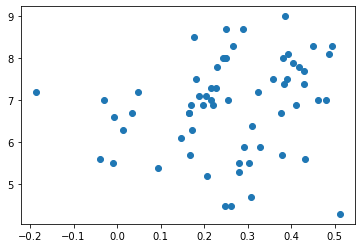

In [106]:
mask = df.num_comments >= 100
plt.scatter(df[mask].sentiment_agg, df[mask].averageRating)

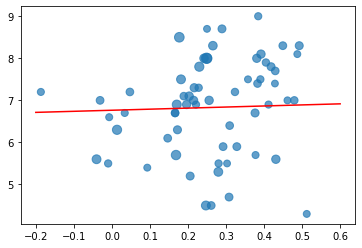

In [314]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(df[mask]['sentiment_agg'].to_numpy().reshape(-1, 1), df[mask].averageRating.to_numpy())
lr.score(df[mask]['sentiment_agg'].to_numpy().reshape(-1, 1), df[mask].averageRating.to_numpy())

mask = df['num_comments'] > 100

fig, ax = plt.subplots()
ax.scatter(df[mask]['sentiment_agg'], df[mask].averageRating, s=np.log(df[mask]['num_comments'])*10, alpha=.7)
x = np.linspace(-.2, .6, 100000).reshape(-1, 1)
y = lr.predict(x)
ax.plot(x, y, color='red')

(0.0, 10.0)

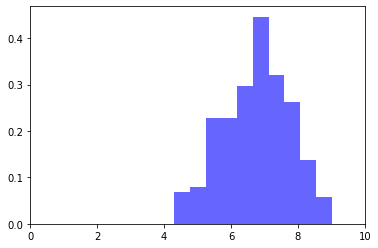

In [148]:
fig, ax = plt.subplots()
ax.hist(df.averageRating, color='blue', alpha=.6, density=True)
ax.set_xlim(0,10)

In [111]:
mean = df.sentiment_agg.mean()
mask = df.sentiment_agg >= mean
df['sentiment_class'] = mask.apply(lambda x: 'upper' if x else 'lower')

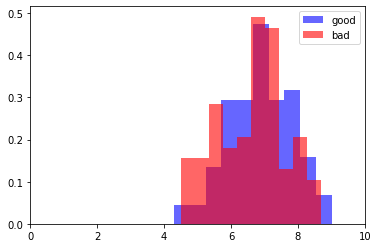

In [114]:
fig, ax = plt.subplots()
ax.hist(df[mask].averageRating, color='blue', alpha=.6, label='good', density=True)
ax.hist(df[~mask].averageRating, color='red', alpha=.6, label='bad', density=True)
ax.set_xlim(0,10)
ax.legend()

In [130]:
from scipy.stats import norm

In [138]:
# good = np.random.normal(loc=np.mean(df[mask].averageRating), scale=np.var(df[mask].averageRating), size=1000)
good = norm(loc=np.mean(df[mask].averageRating), scale=np.var(df[mask].averageRating))
bad = norm(loc=np.mean(df[~mask].averageRating), scale=np.var(df[~mask].averageRating))

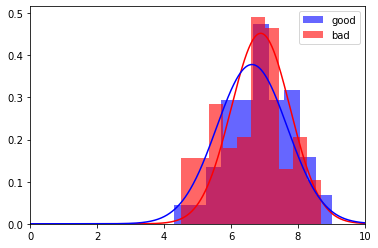

In [140]:
fig, ax = plt.subplots()
ax.hist(df[mask].averageRating, color='blue', alpha=.6, label='good', density=True)
ax.hist(df[~mask].averageRating, color='red', alpha=.6, label='bad', density=True)

x = np.linspace(0, 10, 10000)
ax.plot(x, good.pdf(x), color='red')
ax.plot(x, bad.pdf(x), color='blue')

ax.set_xlim(0,10)
ax.legend()

In [310]:
from scipy import stats
stats.shapiro(df[mask].averageRating)

ShapiroResult(statistic=0.9870291352272034, pvalue=0.48501065373420715)